In [1]:
%load_ext autoreload
%autoreload 2

b0: 4.283621299649987e-05 | b1: 8.567242599299973e-05 | b2: 4.283621299649987e-05 | a0: 1.0092571397251375 | a1: -1.999828655148014 | a2: 0.9907428602748625


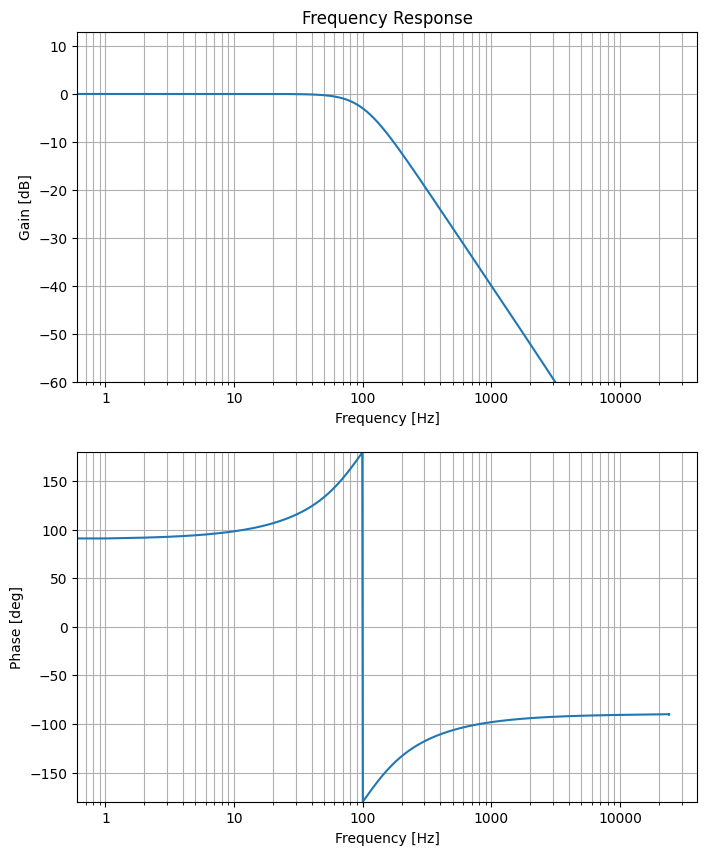

In [2]:
import CustomEq as Eq

fs = 48000

filter = Eq.Lowpass(Eq.FilterParameters.Q(0, 100, fs, 0.707))
filter.plotFreqResponse(True, True)

b0: 1.0011638808198302 | b1: -1.9999982865272583 | b2: 0.9988361191801697 | a0: 1.0003680514315647 | a1: -1.9999982865272583 | a2: 0.9996319485684352
b0: 1.0043638140581845 | b1: -1.999828655148014 | b2: 0.9956361859418155 | a0: 1.0024539529803638 | a1: -1.999828655148014 | a2: 0.9975460470196362
b0: 1.004127600617243 | b1: -1.9828897227476208 | b2: 0.9958723993827568 | a0: 1.0412760061724313 | a1: -1.9828897227476208 | a2: 0.9587239938275687
b0: 1.0096592582628907 | b1: -0.5176380902050415 | b2: 0.9903407417371093 | a0: 1.9659258262890682 | a1: -0.5176380902050415 | a2: 0.0340741737109318
b0: 1.0096592582628907 | b1: 0.5176380902050413 | b2: 0.9903407417371093 | a0: 1.9659258262890682 | a1: 0.5176380902050413 | a2: 0.0340741737109318
b0: 1.005 | b1: 1.7320508075688774 | b2: 0.995 | a0: 1.5 | a1: 1.7320508075688774 | a2: 0.5
b0: 1.0003141075907813 | b1: -1.9990131207314632 | b2: 0.9996858924092187 | a0: 1.0314107590781283 | a1: -1.9990131207314632 | a2: 0.9685892409218717
b0: 1.0005233

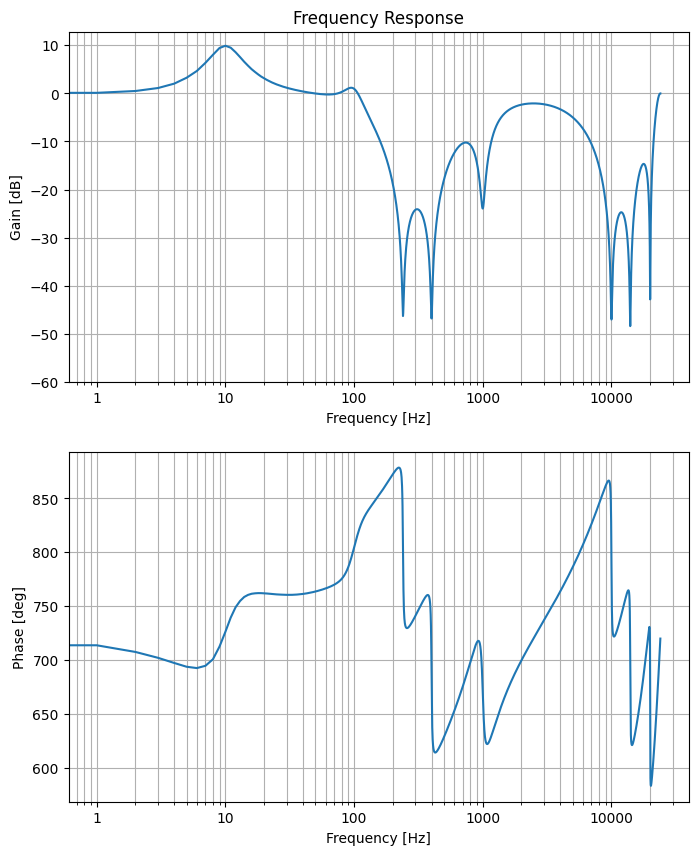

In [3]:
import CustomEq as Eq

fs = 48000
f1 = 10
f2 = 100
f3 = 1000
f4 = 10000
f5 = 14000
f6 = 20000
f7 = 240
f8 = 400

collection = Eq.FilterCollection([
    Eq.PeakingEQ(Eq.FilterParameters.Q(10, f1, fs, 1)), 
    Eq.PeakingEQ(Eq.FilterParameters.Q(5, f2, fs, 2)), 
    Eq.PeakingEQ(Eq.FilterParameters.Q(-20, f3, fs, 5)),
    Eq.PeakingEQ(Eq.FilterParameters.Q(-40, f4, fs, 5)),
    Eq.PeakingEQ(Eq.FilterParameters.Q(-40, f5, fs, 5)),
    Eq.PeakingEQ(Eq.FilterParameters.Q(-40, f6, fs, 5)),    
    Eq.PeakingEQ(Eq.FilterParameters.Q(-40, f7, fs, 5)),
    Eq.PeakingEQ(Eq.FilterParameters.Q(-40, f8, fs, 5))
], fs)
collection.plotFreqResponse(True, True)

In [28]:
import wave
import numpy as np
from typing import Callable
import fxpmath as fp

class AudioEffectApplier:
    def __init__(self, filePath: str, outputFilePath: str, fractional_bits=15):
        self.outputFilePath = outputFilePath
        self.audiofile = wave.open(filePath, "r")
        self.fractional_bits = fractional_bits
        # Save audiofile parameters
        self.sampleWidth = self.audiofile.getsampwidth()
        self.channels = self.audiofile.getnchannels()
        self.frames = self.audiofile.getnframes()
        self.fs = self.audiofile.getframerate()

        print(self.audiofile.getparams())

        # Read audio file to buffer
        raw_input_audio_buffer = self.audiofile.readframes(self.frames)
        pcm_int16 = np.frombuffer(raw_input_audio_buffer, dtype=np.int16)

        #Convert and normalize
        pcm_float32 = pcm_int16.astype(np.float32) / 2**fractional_bits

        self.pcm_left = np.array([pcm_float32[i] for i in range(0, len(pcm_float32) - 1, 2)], dtype=np.float32)
        self.pcm_right = np.array([pcm_float32[i] for i in range(1, len(pcm_float32), 2)], dtype=np.float32)

        # Close file
        self.audiofile.close()

    def signed(self, n, bits=16):
        n &= (1 << bits) - 1 
        if n >> (bits - 1):
            n -= 1 << bits
        return n

    def to_float(self, x: int, n: int):
        c = abs(int(x))
        sign = 1
        if (x < 0):
            c = int(x) - 1
            c = ~c
            sign = -1
        f = float((1.0 * c) / 2**n)
        f = f*sign
        return f
    
    def to_fixed(self, f: float, n: int):
        a = f*(2**n)
        b = int(round(a))
        if (a < 0):
            b = abs(b)
            b = ~b
            b = b + 1
        return b


    def process(self, f: Callable[[np.ndarray], np.ndarray]):
        filtered_pcm_left: np.ndarray[np.float32] = f(np.copy(self.pcm_left)).astype(np.float32)
        filtered_pcm_right: np.ndarray[np.float32] = f(np.copy(self.pcm_right)).astype(np.float32)

        # Normalize
        filtered_pcm_left: np.ndarray[np.float32] = np.array(filtered_pcm_left / np.max(filtered_pcm_left)).astype(np.float32)
        filtered_pcm_right: np.ndarray[np.float32] = np.array(filtered_pcm_right / np.max(filtered_pcm_right)).astype(np.float32)

        #Convert back to fixedpoint integers
        converted_pcm_left: np.ndarray[np.int16] = np.array([pcm * (2**self.fractional_bits - 1) for pcm in filtered_pcm_left]).astype(dtype=np.int16)
        converted_pcm_right: np.ndarray[np.int16] = np.array([pcm * (2**self.fractional_bits - 1) for pcm in filtered_pcm_right]).astype(dtype=np.int16)

        raw_write: bytes = b'' 
        for i_pcm in range(len(converted_pcm_left)):
            raw_write += np.int16.tobytes(converted_pcm_left[i_pcm])
            raw_write += np.int16.tobytes(converted_pcm_right[i_pcm])

        outputFile = open(self.outputFilePath, "wb")
        writer = wave.Wave_write(outputFile)
        writer.setframerate(self.fs)
        writer.setnchannels(self.channels)
        writer.setnframes(self.frames)
        writer.setsampwidth(self.sampleWidth)
        writer.setcomptype('NONE', 'not compressed')
        writer.writeframesraw(raw_write)
        writer.close()
        outputFile.close()

        return filtered_pcm_left, filtered_pcm_right


_wave_params(nchannels=2, sampwidth=2, framerate=48000, nframes=16928, comptype='NONE', compname='not compressed')
b0: 1.107742521840597 | b1: -1.5867066805824703 | b2: 0.8922574781594032 | a0: 1.2149745935482543 | a1: -1.5867066805824703 | a2: 0.7850254064517457


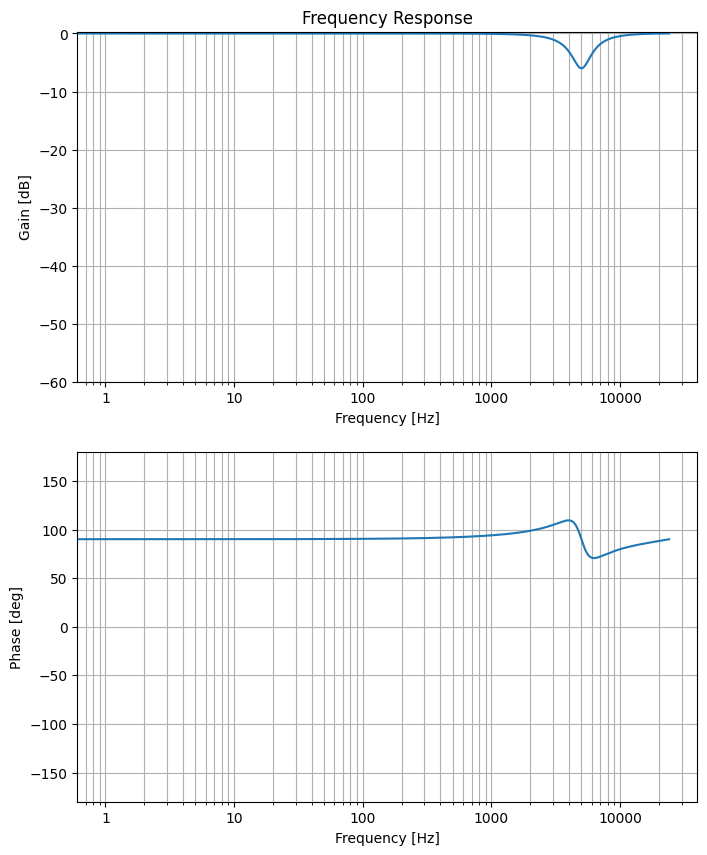

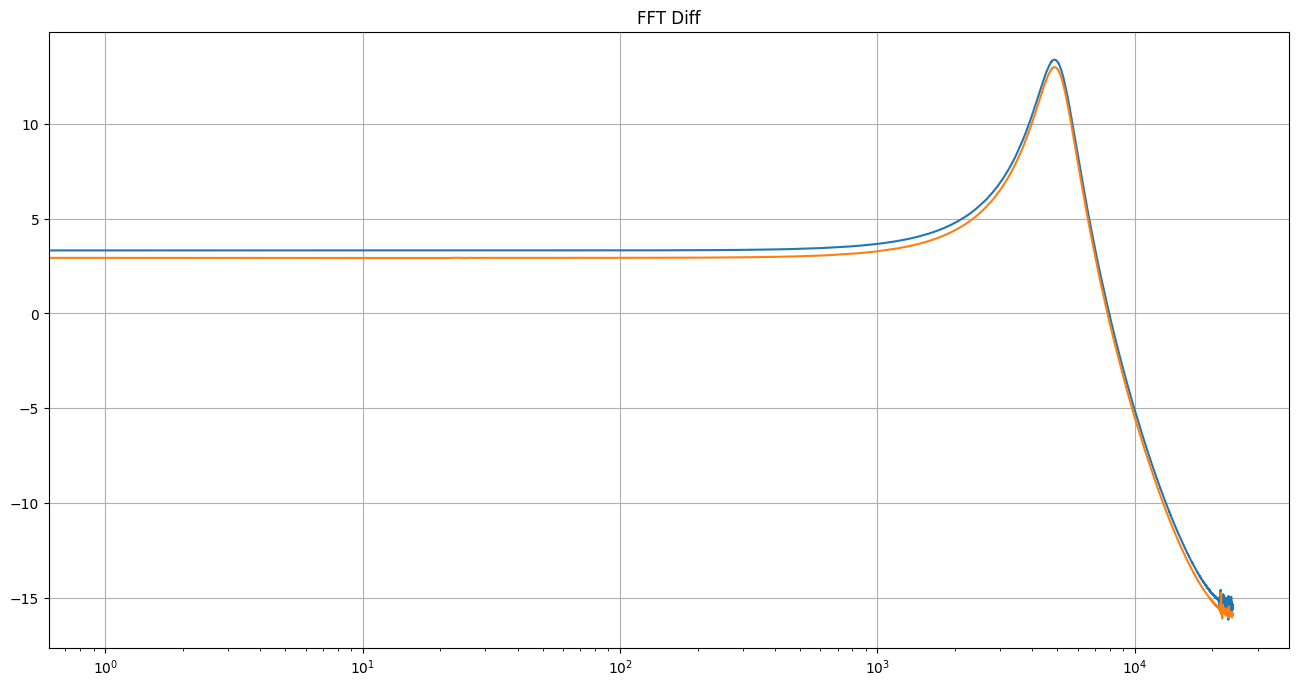

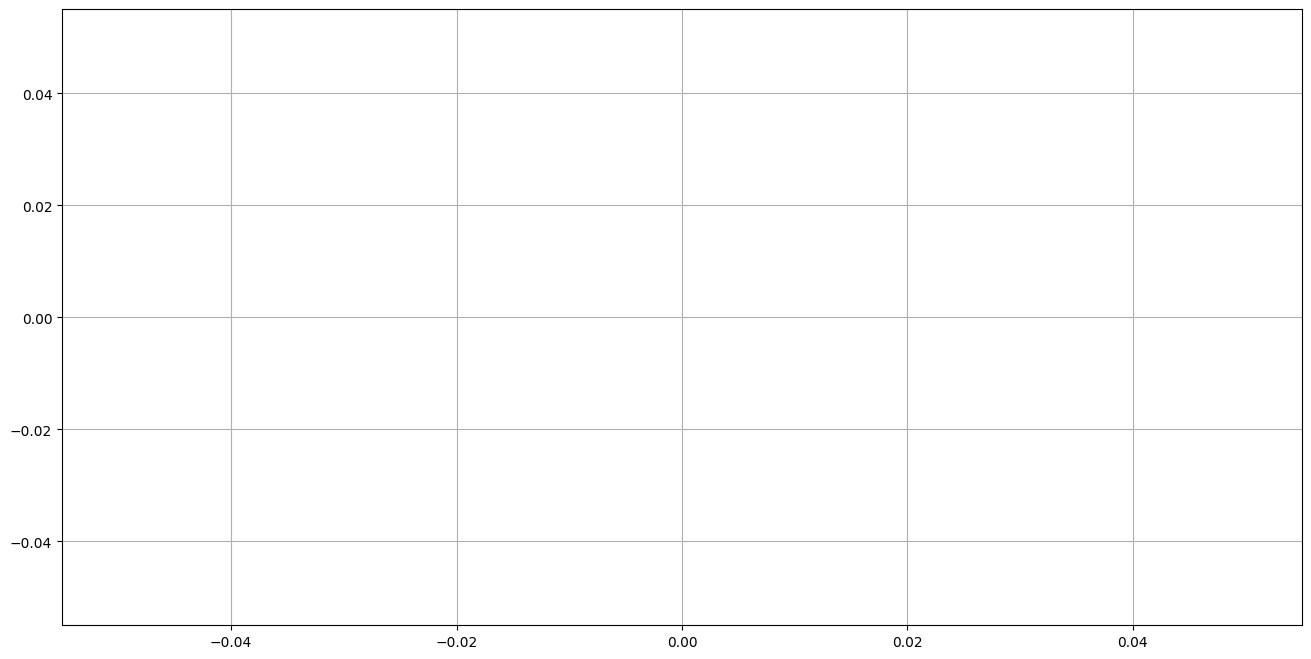

In [30]:
import matplotlib.pyplot as plt
from math import floor

a = AudioEffectApplier("Clap.wav", "Output.wav")
filter = Eq.PeakingEQ(Eq.FilterParameters.Q(-6, 5000, a.fs, 2))


def dummy(x):
    return x

filter.plotFreqResponse(True, True)
filtered_pcm_left, filtered_pcm_right = a.process(filter.process)


fft_before_left = 20 * np.log10(np.abs(np.fft.fft(a.pcm_left, a.fs)))
fft_after_left = 20 * np.log10(np.abs(np.fft.fft(filtered_pcm_left, a.fs)))
fft_before_right = 20 * np.log10(np.abs(np.fft.fft(a.pcm_right, a.fs)))
fft_after_right = 20 * np.log10(np.abs(np.fft.fft(filtered_pcm_right, a.fs)))



fig = plt.figure()
fig.set_size_inches(16, 8)
ax = fig.add_subplot(1,1,1)
ax.semilogx(fft_before_left[0:floor(a.fs/2)] - fft_after_left[0:floor(a.fs/2)])
ax.semilogx(fft_before_right[0:floor(a.fs/2)] - fft_after_right[0:floor(a.fs/2)])
ax.grid(True)
ax.set_title("FFT Diff")

fig2 = plt.figure()
fig2.set_size_inches(16, 8)
ax = fig2.add_subplot(1,1,1)
ax.plot(a.pcm_left[20000:21000])#[20000:20200])
ax.plot(filtered_pcm_left[20000:21000])#[20000:20200])# - fft_after_left[0:floor(a.fs/2)])
ax.grid(True)

_wave_params(nchannels=2, sampwidth=2, framerate=48000, nframes=16928, comptype='NONE', compname='not compressed')
b0: 1.0164594528993485 | b1: -1.999828655148014 | b2: 0.9835405471006516 | a0: 1.0052049360202202 | a1: -1.999828655148014 | a2: 0.9947950639797797
b0: 1.077658113414933 | b1: -1.9828897227476208 | b2: 0.922341886585067 | a0: 1.1096950008431647 | a1: -1.9828897227476208 | a2: 0.8903049991568351
b0: 1.0742813892148138 | b1: -1.7320508075688774 | b2: 0.9257186107851864 | a0: 1.0525871963528246 | a1: -1.7320508075688774 | a2: 0.9474128036471753
[<CustomEq.PeakingEQ object at 0x00000196D445DEE0>, <CustomEq.PeakingEQ object at 0x00000196D445EE40>, <CustomEq.PeakingEQ object at 0x00000196D58E2F00>]
[[8482528, -16688912, 8207814, -16688912, 8301735], [8146428, -14989418, 6972333, -14989418, 6730154], [8561499, -13803601, 7377526, -13803601, 7550418]]
166.03667


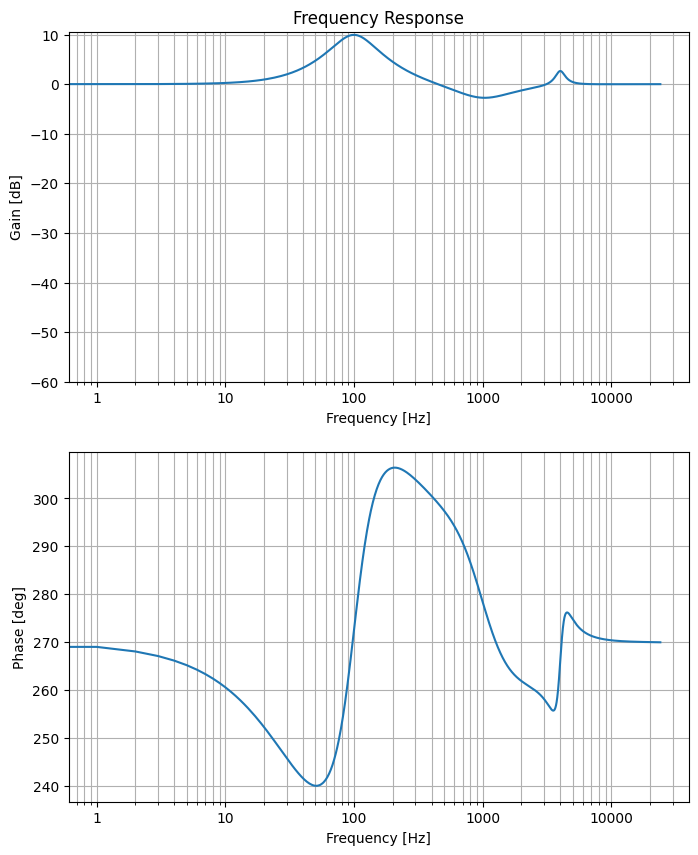

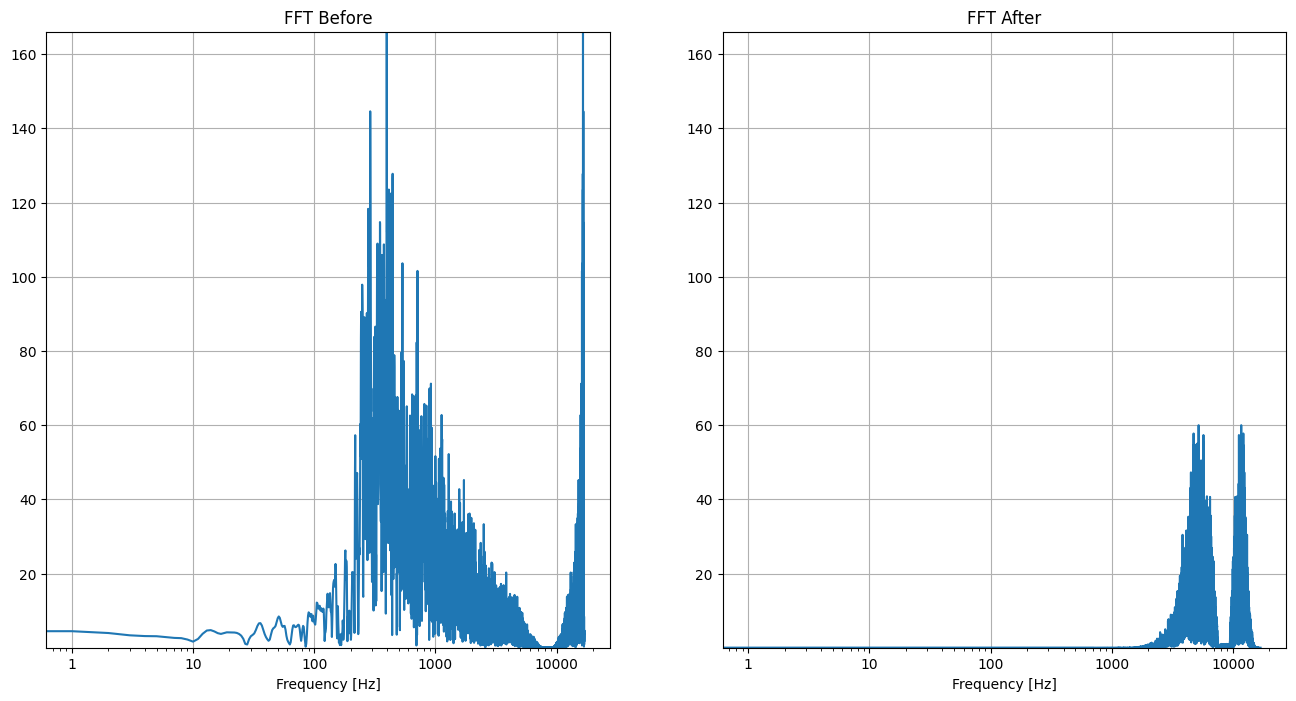

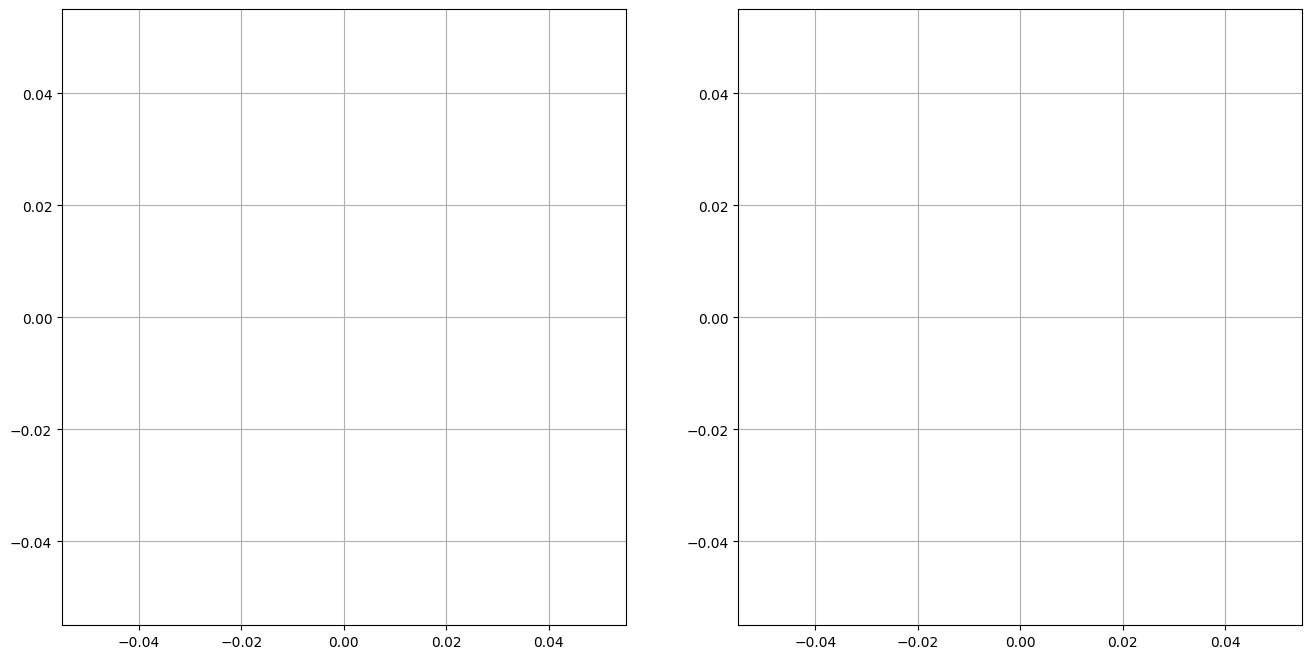

In [31]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from math import floor
import CustomEq as Eq

EffectApplier = AudioEffectApplier("Clap.wav", "Output.wav", fractional_bits=15)

collection = Eq.FilterCollection([
    #Eq.LowShelf(Eq.FilterParameters.S(6, 1000, a.fs, 1)),
    Eq.PeakingEQ(Eq.FilterParameters.Q(10, 100, a.fs, 0.7071)),
    Eq.PeakingEQ(Eq.FilterParameters.Q(-3, 1000, EffectApplier.fs, 0.7071)),
    Eq.PeakingEQ(Eq.FilterParameters.Q(3, 4000, a.fs, 4)),
    #Eq.Lowpass(Eq.FilterParameters.Q(0, 500, EffectApplier.fs, 0.7071))
], EffectApplier.fs)
collection.plotFreqResponse(True, True)
print(collection.coeffs(True, 23))


pcm_left, pcm_right = EffectApplier.process(collection.process)

fft_before = np.abs(np.fft.fft(EffectApplier.pcm_left))
fft_after = np.abs(np.fft.fft(pcm_left))

fft_before_max = max(fft_before)
fft_before_min = min(fft_before)
print(fft_before_max)



fig = plt.figure()
fig.set_size_inches(16, 8)
ax1 = fig.add_subplot(1,2,1)
ax1.semilogx(fft_before[:floor(EffectApplier.fs/2)])
ax1.grid(True)
ax1.set_title("FFT Before")
ax1.set_xlabel("Frequency [Hz]")
ax1.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x))))
ax1.set_ylim(bottom=fft_before_min, top=fft_before_max)


ax2 = fig.add_subplot(1,2,2)
ax2.semilogx(fft_after[:floor(EffectApplier.fs/2)])
ax2.grid(True)
ax2.set_title("FFT After")
ax2.set_xlabel("Frequency [Hz]")
ax2.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x))))
ax2.set_ylim(bottom=fft_before_min, top=fft_before_max)

fig2 = plt.figure()
fig2.set_size_inches(16, 8)
ax = fig2.add_subplot(1,2,1)
ax.plot(EffectApplier.pcm_left[20000:20100])
ax.grid(True)
ax2 = fig2.add_subplot(1,2,2)
ax2.plot(pcm_left[20000:20100])
ax2.grid(True)
